To Do :


*   adjust lsmt with next word prediction
*   add to lsmt the PoS tag for better training
* add to lstm a self attention layer
* try to train GRU
*  finetuning GPT
* finetutning of DistilBert
* use hugginface for sentiment analysis
* extract statistic on text
* use  Gan for text generator , but it need to find a descriminator




Model saved :

*   model_final_pred_lstm.h5 = final word , 0.65 accu , loss 1.6 , 1k , 25 epo -> generate word but without sense
*   



# Load Library and Drive

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
drive.mount('/content/drive')
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint


Mounted at /content/drive


In [ ]:
import pandas as pd
dataset_path = '/content/drive/My Drive/nlp/dataset/shortjokes.csv'
df_dataset = pd.read_csv(dataset_path)
df_dataset

,ID,Joke
0,1,"[me narrating a documentary about narrators] ""..."
1,2,Telling my daughter garlic is good for you. Go...
2,3,I've been going through a really rough period ...
3,4,"If I could have dinner with anyone, dead or al..."
4,5,Two guys walk into a bar. The third guy ducks.
...,...,...
231652,231653,The Spicy Sausage by Delia Katessen
231653,231654,"TIL That I Shouldn't have gone to law school, ..."
231654,231655,What did the RAM stick say to the politician? ...
231655,231656,what do you call a play about victorian era me...


# Cleaning Pipeline

In [ ]:
import re

def clean_text(text):
    # Remove HTML tags
    html = re.compile('[<,#*?>]')
    text = html.sub(r'', text)

    # Remove URLs
    url = re.compile('https?://\S+|www\.S+')
    text = url.sub(r'', text)

    # Remove email addresses
    email = re.compile('[A-Za-z0-2]+@[\w]+.[\w]+')
    text = email.sub(r'', text)

    # Remove punctuation
    punctuation = re.compile('[^\w\s]')
    text = punctuation.sub(r'', text)

    # Remove numbers
    numbers = re.compile('\d+')
    text = numbers.sub(r'', text)

    # Remove non-ASCII characters
    non_ascii = re.compile('[^\x00-\x7F]+')
    text = non_ascii.sub(r'', text)

    #remove escape sequences
    newline_pattern = re.compile(r'\r\n|\r|\n')
    text = newline_pattern.sub('', text)

    #lower case
    text = text.lower()

    return text

In [ ]:
df_dataset['Joke'] = df_dataset['Joke'].apply(clean_text)
df_dataset

,ID,Joke
0,1,me narrating a documentary about narrators i c...
1,2,telling my daughter garlic is good for you goo...
2,3,ive been going through a really rough period a...
3,4,if i could have dinner with anyone dead or ali...
4,5,two guys walk into a bar the third guy ducks
...,...,...
231652,231653,the spicy sausage by delia katessen
231653,231654,til that i shouldnt have gone to law school be...
231654,231655,what did the ram stick say to the politician i...
231655,231656,what do you call a play about victorian era me...


In [ ]:
# Aggiungi i token SOS ed EOS a ogni joke
df_dataset['Joke'] = 'sos ' + df_dataset['Joke'] + ' eos'
df_dataset

,ID,Joke
0,1,sos me narrating a documentary about narrators...
1,2,sos telling my daughter garlic is good for you...
2,3,sos ive been going through a really rough peri...
3,4,sos if i could have dinner with anyone dead or...
4,5,sos two guys walk into a bar the third guy duc...
...,...,...
231652,231653,sos the spicy sausage by delia katessen eos
231653,231654,sos til that i shouldnt have gone to law schoo...
231654,231655,sos what did the ram stick say to the politici...
231655,231656,sos what do you call a play about victorian er...


# LSTM

In [ ]:
import tensorflow as tf

import numpy as np
import os
import time
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np


In [ ]:
df_dataset100 = df_dataset.head(100)
df_dataset300 = df_dataset.head(300)
df_dataset500 = df_dataset.head(500)
df_dataset1k = df_dataset.head(1000)


- training a   parola intermedia , sto allenando usando la tecnica Next Word Prediction , adatta alla generazione di nuovo testo.
- posso usare anche i tag PoS per imporre una struttura semantica e allenare , tecnica gia usata in letteratura

## Training only with Next word prediction

In [ ]:
df_dataset = df_dataset500

# Preprocessa i dati testuali
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_dataset['Joke'])

total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in df_dataset['Joke']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, 1:]  # Cambiato il target per includere tutte le parole tranne la prima
y = np.array(y)

# Costruisci il modello LSTM con migliorie
model = Sequential()
model.add(Embedding(total_words, 70, input_length=max_sequence_length-1))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=l2(0.01), return_sequences=True))
model.add(BatchNormalization())
model.add(Dense(total_words, activation='softmax'))

# Schedule dinamico del tasso di apprendimento
def lr_schedule(epoch):
    return 0.001 * 0.7**epoch

model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Addestra il modello
history = model.fit(X, y, epochs=15, verbose=1)


Epoch 1/15
287/287 [==============================] - 46s 145ms/step - loss: 2.9313 - accuracy: 0.6911
Epoch 2/15
287/287 [==============================] - 48s 167ms/step - loss: 1.6778 - accuracy: 0.7233
Epoch 3/15
287/287 [==============================] - 55s 193ms/step - loss: 1.4862 - accuracy: 0.7297
Epoch 4/15
287/287 [==============================] - 44s 152ms/step - loss: 1.3201 - accuracy: 0.7386
Epoch 5/15
287/287 [==============================] - 39s 136ms/step - loss: 1.1664 - accuracy: 0.7549
Epoch 6/15
287/287 [==============================] - 39s 135ms/step - loss: 1.0083 - accuracy: 0.7799
Epoch 7/15
287/287 [==============================] - 39s 136ms/step - loss: 0.8674 - accuracy: 0.8057
Epoch 8/15
287/287 [==============================] - 39s 135ms/step - loss: 0.7473 - accuracy: 0.8287
Epoch 9/15
287/287 [==============================] - 41s 142ms/step - loss: 0.6470 - accuracy: 0.8507
Epoch 10/15
287/287 [==============================] - 39s 136ms/step - l

In [ ]:
# Genera nuovi Jokes
seed_text = "sos In a pub, a guy with a gun with a pub kala"
next_words = 1

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)[0]

    # Ottieni l'indice della parola predetta con probabilità massima
    predicted = np.argmax(predicted_probs)
    # Ottieni la parola corrispondente all'indice
    output_word = tokenizer.index_word.get(predicted, "")
    print(output_word)
    # Aggiungi la parola predetta al testo in corso
    seed_text += " " + output_word

    # Verifica se la parola predetta è EOS e interrompi la generazione
    if output_word == 'eos':
        break

print(seed_text)



sos In a pub, a guy with a gun with a pub kala 


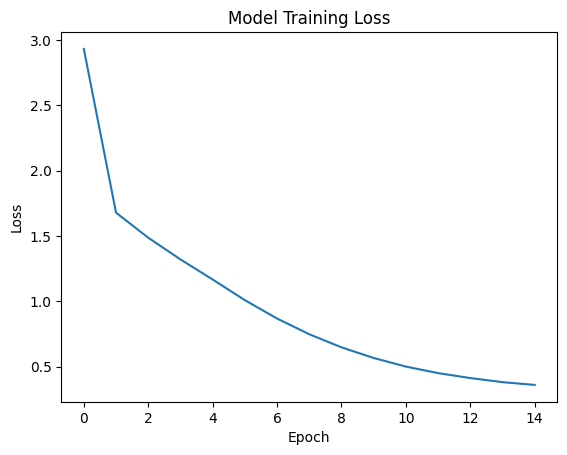

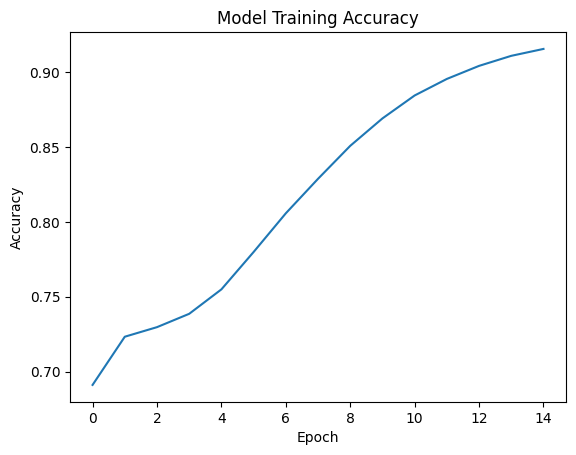

In [ ]:
# Visualizza la perdita durante l'addestramento
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualizza l'accuratezza durante l'addestramento
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## Training only with *final word prediction*

In [ ]:
df_dataset = df_dataset1k

# Preprocessa i dati testuali
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_dataset['Joke'])

total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in df_dataset['Joke']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='pre')

X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = np.array(y)

# Costruisci il modello LSTM con migliorie
model = Sequential()
model.add(Embedding(total_words, 70, input_length=max_sequence_length-1))  # Aumento della dimensione dell'Embedding
model.add(LSTM(100, return_sequences=True))  # Aggiunto un secondo strato LSTM
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.1, kernel_regularizer=l2(0.01)))  # Dropout diversificato e regolarizzazione L2
model.add(BatchNormalization())  # Batch Normalization
model.add(Dense(total_words, activation='softmax'))

# Schedule dinamico del tasso di apprendimento
def lr_schedule(epoch):
    return 0.001 * 0.7**epoch

model.compile(optimizer=Adam(learning_rate=lr_schedule(0)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Definisci il percorso del file in cui verrà salvato il modello
model_path = '/content/drive/My Drive/nlp/model/final_pred_lstm.h5'

# Aggiungi il controllo del modello durante l'addestramento
checkpoint = ModelCheckpoint(model_path, monitor='loss', save_best_only=True)

# Addestra il modello
history = model.fit(X, y, epochs=25, verbose=1)


Epoch 1/25
567/567 [==============================] - 104s 168ms/step - loss: 7.3133 - accuracy: 0.0734
Epoch 2/25
567/567 [==============================] - 79s 139ms/step - loss: 6.2464 - accuracy: 0.0908
Epoch 3/25
567/567 [==============================] - 80s 140ms/step - loss: 5.9052 - accuracy: 0.1089
Epoch 4/25
567/567 [==============================] - 78s 138ms/step - loss: 5.6167 - accuracy: 0.1187
Epoch 5/25
567/567 [==============================] - 77s 135ms/step - loss: 5.3300 - accuracy: 0.1317
Epoch 6/25
567/567 [==============================] - 77s 136ms/step - loss: 5.0324 - accuracy: 0.1468
Epoch 7/25
567/567 [==============================] - 77s 136ms/step - loss: 4.7212 - accuracy: 0.1677
Epoch 8/25
567/567 [==============================] - 81s 142ms/step - loss: 4.4128 - accuracy: 0.1909
Epoch 9/25
567/567 [==============================] - 77s 135ms/step - loss: 4.1020 - accuracy: 0.2225
Epoch 10/25
567/567 [==============================] - 77s 136ms/step - 

In [ ]:
model_path = '/content/drive/My Drive/nlp/model/model_final_pred_lstm.h5'

model.save(model_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Genera nuovi Jokes
seed_text = "sos In a school, "
next_words = 10

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_length-1, padding='pre')
    predicted_probs = model.predict(token_list, verbose=0)[0]

    # Ottieni l'indice della parola predetta con probabilità massima
    predicted = np.argmax(predicted_probs)

    # Ottieni la parola corrispondente all'indice
    output_word = tokenizer.index_word.get(predicted, "")

    # Aggiungi la parola predetta al testo in corso
    seed_text += " " + output_word

    # Verifica se la parola predetta è EOS e interrompi la generazione
    if output_word == 'eos':
        break

print(seed_text)


sos In a  school,  donald of say whats my black please have a heart


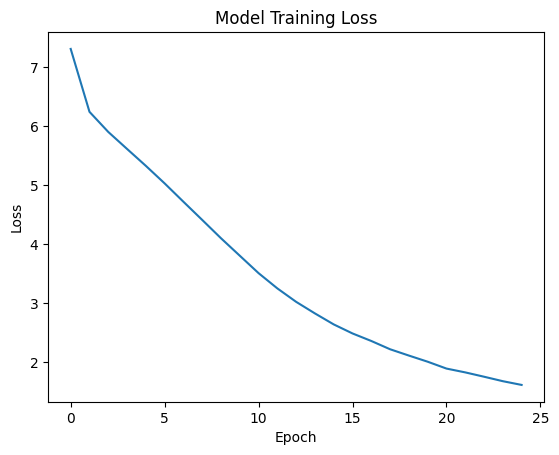

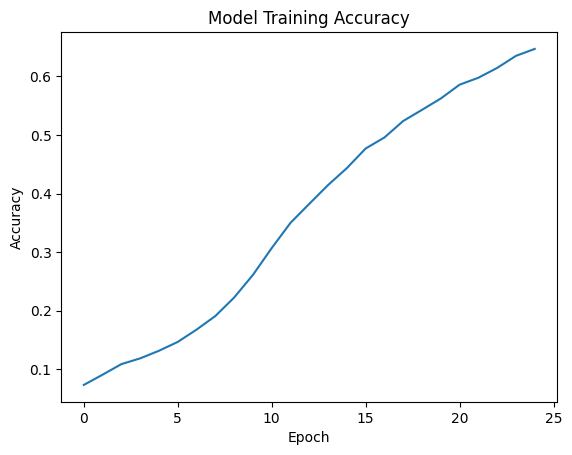

In [ ]:
# Visualizza la perdita durante l'addestramento
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualizza l'accuratezza durante l'addestramento
plt.plot(history.history['accuracy'])
plt.title('Model Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Sentiment Analysis with DistiLbert

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained DistilBERT model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name)
from transformers import pipeline


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
sentiment_analysis_pipeline = pipeline(
    "sentiment-analysis",
    model=model_name,
    tokenizer=model_name
)

# Example text for sentiment analysis
text = "I  using DistilBERT "

# Perform sentiment analysis
result = sentiment_analysis_pipeline(text)

# Print the result
result

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'LABEL_0', 'score': 0.5336849689483643}]